In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import scipy.stats as stats
import math

import sys 
sys.path.insert(1, '/media3/etienne/workdir/spark_AGN/Build_classifier')
import classifier_tools as ct

def Gauss(x, A, mu, sig):
    y = A*np.exp(-(x-mu)**2/(2*sig**2))
    return y


In [16]:
######## USER ########

balanced = True
name_1 = 'ELASTICC_TRAIN_SNIa-SALT2_bazin_cut_features' #_bazin_cut
name_2 = 'ELASTICC_TRAIN_SNIb+HostXT_V19_bazin_cut_features'

main_file = 'bazin_features'

######## USER ########

features_1 = pd.read_parquet(f'{main_file}/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'{main_file}/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    nobj = min(len(features_1), len(features_2))
    bazin_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    bazin_features = pd.concat([features_1, features_2])


main_file = 'features'

features_1 = pd.read_parquet(f'{main_file}/{name_1}.parquet')
features_1['target']='Ia'
features_2 = pd.read_parquet(f'{main_file}/{name_2}.parquet')
features_2['target']='Ib'

if balanced:
    kostya_features = pd.concat([features_1[:nobj], features_2[:nobj]])
    
else:
    kostya_features = pd.concat([features_1, features_2])
    
    
methods = [[bazin_features, 'Bazin'], [kostya_features, 'Kostya']]

In [20]:
kostya_features

,a,t0,tT,tfall,trise,Tmin,dT,ksig,error,max_flux,max_time,true_peak,target
0,1.183698,-4.586774,19.348954,31.322340,-2.613161,3434.523585,4081.889936,2.943163,38.907986,162.057526,61116.3296,61119.742188,Ia
1,1.267530,-6.617833,23.716707,32.301883,-3.176208,3414.468733,3345.242122,7.828049,140.870150,181.768494,61243.2724,61245.789062,Ia
2,1.566943,-5.937911,-38.306113,37.619444,-4.042911,2924.018746,20558.723400,24.530911,69.338970,76.893570,61122.2391,61127.230469,Ia
3,18.454827,-64.977956,-12.741018,34.176442,-11.815950,4087.010221,15651.767336,1.705252,66.064325,20.431032,61261.1869,61197.882812,Ia
4,1.859862,1.435366,19.680615,20.757375,-4.961221,4342.670805,3359.543227,0.601347,83.727763,96.432365,60944.2313,60952.753906,Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9741,1.769774,-0.493970,5.837230,42.707399,-3.799274,4300.727962,2321.826733,0.196440,137.453745,129.921631,61235.1594,61245.515625,Ib
9742,1.051454,-4.554065,22.216419,48.630953,-0.250494,3500.960849,2462.701544,2.301521,30.205324,94.576347,61236.0813,61235.769531,Ib
9743,2.280188,-22.461276,-21.735421,59.903810,-0.499790,3435.552792,76965.302015,10.324971,64.871601,51.170750,60650.2242,60642.492188,Ib
9744,1.316288,-10.545993,14.075007,50.269394,-3.677553,3475.991098,3971.751748,6.859748,112.007503,103.001411,60774.3541,60773.917969,Ib


# Predict the target

Bazin : Accuracy on testing sample is : 87.55%
Efficiency : 88.62% of real Ia were labeled as Ia
Purity : 86.91% of classified Ia were indeed Ia


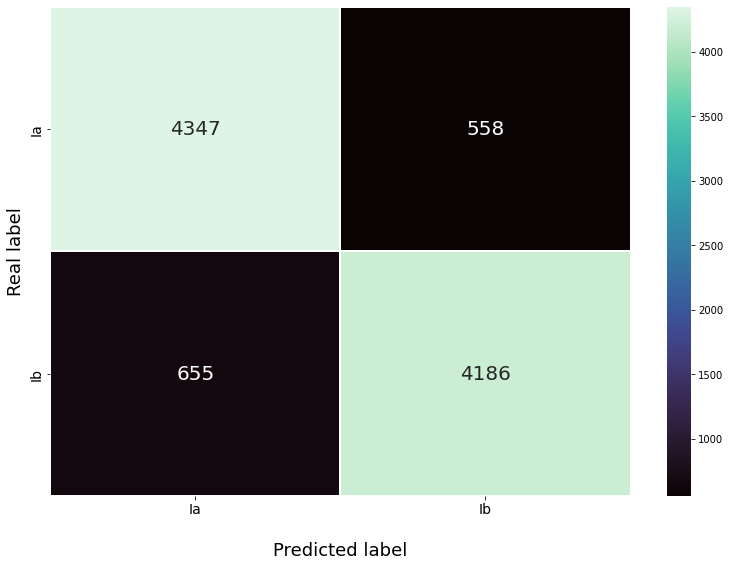

Kostya : Accuracy on testing sample is : 89.63%
Efficiency : 90.78% of real Ia were labeled as Ia
Purity : 88.85% of classified Ia were indeed Ia


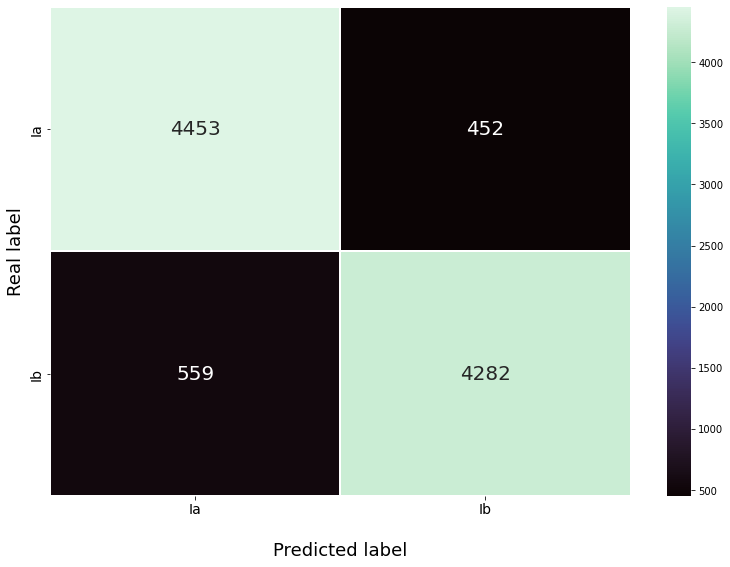

In [17]:
seed = 42

rf = {}

for features in methods:
    
    X_train, X_test, y_train, y_test = train_test_split(features[0].iloc[:,:-2], features[0]['target'], test_size=0.5, random_state=seed)
    clf = RandomForestClassifier(n_estimators = 100, random_state=seed)
    clf.fit(X_train, y_train)
    
    rf[features[1]] = clf

    score = clf.score(X_test, y_test)
    print(f'{features[1]} : Accuracy on testing sample is : {score*100:.2f}%')
    ct.draw_confusion(clf, X_test, y_test, interest='Ia')

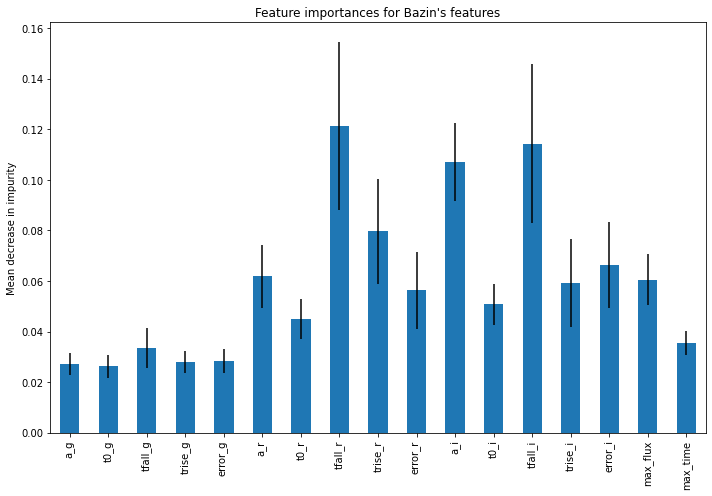

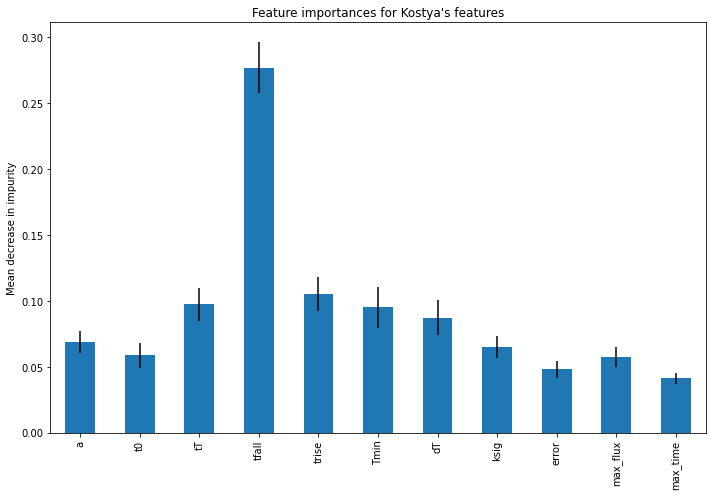

In [13]:
for idx, features in enumerate(methods):
    
    importances = rf[features[1]].feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf[features[1]].estimators_], axis=0)

    forest_importances = pd.Series(importances, index=features[0].iloc[:, :-2].keys())
    fig, ax = plt.subplots(figsize = (10, 7))


    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Feature importances for {features[1]}'s features")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

# How good is t0 prediction

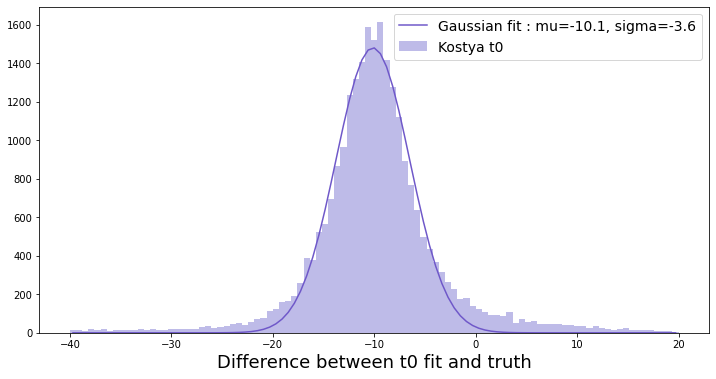

In [14]:
prediction = kostya_features['t0'] + kostya_features['max_time'] 
diff = prediction - kostya_features['true_peak']

bins = np.linspace(-40, 20, 100)

plt.figure(figsize =(12,6))
plt.xlabel("Difference between t0 fit and truth", fontsize = 18)

(n, b, patches) = plt.hist(diff, bins=bins, alpha=0.5, color='#7E78D2', label='Kostya t0');

width = b[1] - b[0]
center_bins = b[:-1]+(width/2)

parameters, covariance = curve_fit(Gauss, center_bins, n)

plt.plot(center_bins, Gauss(center_bins, *parameters), color='#6F58C9',\
             label=f"Gaussian fit : mu={parameters[1]:.1f}, sigma={parameters[2]:.1f}") 

plt.legend(fontsize = 14)

# Predict the max peak using machine learning

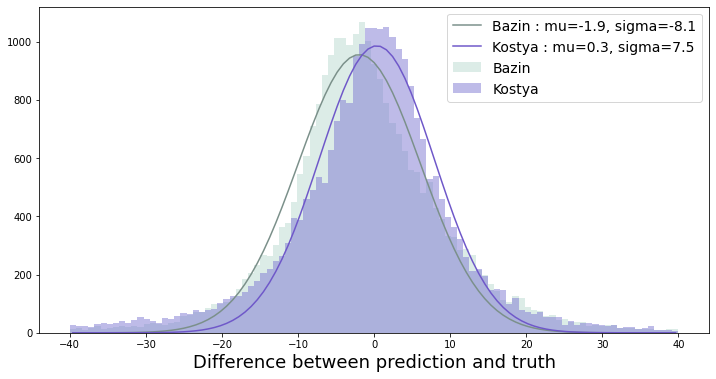

In [15]:
plt.figure(figsize =(12,6))
plt.xlabel("Difference between prediction and truth", fontsize = 18)

for features in methods:
    
    colors = ['#6F58C9', '#7E78D2']
    if features[1] == 'Bazin':
        colors = ['#7B908A', '#BBDBD1']
    
    X = features[0].iloc[:,:-2]
    y = features[0]['true_peak']
    reg = LinearRegression().fit(X, y)
    prediction = reg.predict(features[0].iloc[:,:-2])
    
    diff = prediction - y
    bins = np.linspace(-40, 40, 100)
    
    (n, b, patches) = plt.hist(diff, bins=bins, label=features[1], alpha=0.5, density=False, color=colors[1]);
    
    width = b[1] - b[0]
    center_bins = b[:-1]+(width/2)
    
    parameters, covariance = curve_fit(Gauss, center_bins, n)
    plt.plot(center_bins, Gauss(center_bins, *parameters), color=colors[0],\
             label=f"{features[1]} : mu={parameters[1]:.1f}, sigma={parameters[2]:.1f}") 

    
plt.legend(fontsize = 14)
plt.show()